<a href="https://colab.research.google.com/github/hrumst/ML/blob/NS-gclb-2/gclb2-3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%config IPComplater.greedy = True

In [2]:
from google.colab import drive
drive.mount('./DRIVE', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at ./DRIVE


In [0]:
!rm -rf sample_data

In [0]:
!rm -rf inputs/plates

In [5]:
import shutil, os
shutil.copytree('./DRIVE/My Drive/Colab Notebooks/input/plates', 'inputs/plates')

'inputs/plates'

In [13]:
s = []
s.append(1)
s.append(2)
s.append(3)
s = s[1:]
print(s)

[2, 3]


In [0]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import time
import copy

import torch, torch.nn
from torch import nn
from torchvision import transforms, models
import torchvision

In [15]:
!rm -rf val && rm -rf train

data_root = 'inputs/plates/plates/'
#%%

import shutil 
from tqdm import tqdm

train_dir = 'train'
val_dir = 'val' # validation

class_names = ['cleaned', 'dirty']

# удобное копирование картинок по папкам
for dir_name in [train_dir, val_dir]:
    for class_name in class_names:
        os.makedirs(os.path.join(dir_name, class_name), exist_ok=True)

val_examples = 0
for class_name in class_names:
    source_dir = os.path.join(data_root, 'train', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        # if i % 100 != 0:
        dest_dir = os.path.join(train_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))
        # else:
            # val_examples += 1
            # dest_dir = os.path.join(val_dir, class_name)
            # shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

for class_name in class_names:
    source_dir = os.path.join(data_root, 'ext-test', class_name)
    for i, file_name in enumerate(tqdm(os.listdir(source_dir))):
        val_examples += 1
        dest_dir = os.path.join(val_dir, class_name)
        shutil.copy(os.path.join(source_dir, file_name), os.path.join(dest_dir, file_name))

100%|██████████| 25/25 [00:00<00:00, 4964.38it/s]


In [0]:
import PIL.Image
import random
batch_size = 8

def color_shuffler(pic: PIL.Image):
    arr_pic = np.array(pic)
    sl = [arr_pic[:,:, 0], arr_pic[:,:, 1], arr_pic[:,:, 2]]
    rl = [0,1,2]
    random.shuffle(rl)
    for (i, ri) in enumerate(rl):
        arr_pic[:,:, i] = sl[ri]
    im = PIL.Image.fromarray(arr_pic.astype(np.uint8))
    return im

def color_rand_factory(from_val, to_val):
    def color_rand(pic: PIL.Image):
        arr_pic = np.array(pic)
        rl = random.randint(0,2)
        arr_pic[:,:,rl] = arr_pic[:,:,rl] + random.randint(from_val, to_val)
        im = PIL.Image.fromarray(arr_pic.astype(np.uint8))
        return im
    return color_rand

train_transforms = transforms.Compose([
    # аугментация
    torchvision.transforms.RandomApply([torchvision.transforms.Lambda(color_shuffler)], p=.85),
    torchvision.transforms.RandomApply([torchvision.transforms.Lambda(color_rand_factory(-30,30))], p=.25),
    torchvision.transforms.RandomApply([transforms.ColorJitter()], p=.5),
    transforms.RandomRotation(30),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # нормализация викторов картинок под рез-нет
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    # нормализация викторов картинок под рез-нет
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_dataset = torchvision.datasets.ImageFolder(train_dir, train_transforms)
val_dataset = torchvision.datasets.ImageFolder(val_dir, val_transforms)


In [0]:
def unfreeze_layer(model, layer, params):
    un_freezed = 0
    for name, child in model.named_children():
        if name != layer:
            continue
        for chName, chChild in child.named_children():
            if int(chName) not in params:
                continue
            for (i,param) in enumerate(chChild.parameters()):
                param.requires_grad = True         
                un_freezed += 1
    print('\nUnfreezed for layer#{}: {}'.format(layer, un_freezed))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


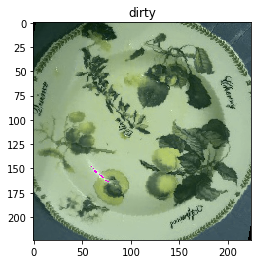

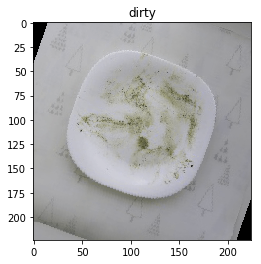

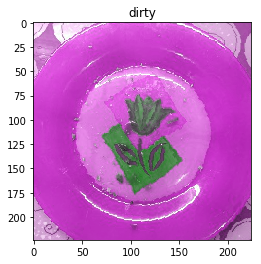

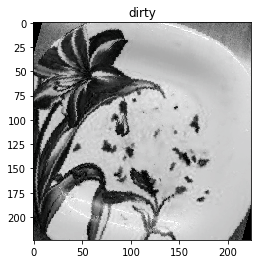

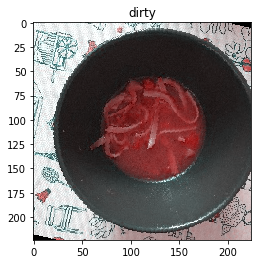

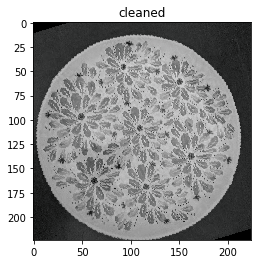

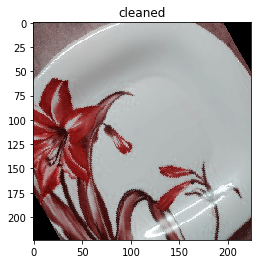

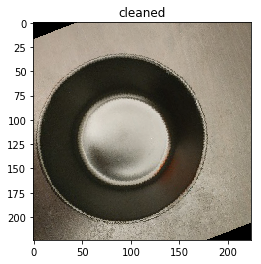

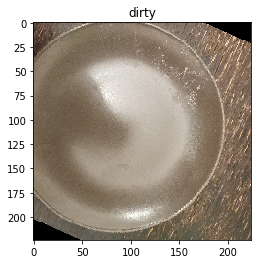

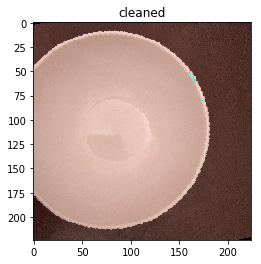

In [21]:
#%%

batch_size = 10
train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)
len(train_dataloader), len(train_dataloader)

X_batch, y_batch = next(iter(train_dataloader))
mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
# денормализация векторов для печати
plt.imshow(X_batch[0].permute(1, 2, 0).numpy() * std + mean);

#%%

def show_input(input_tensor, title=''):
    image = input_tensor.permute(1, 2, 0).numpy()
    image = std * image + mean
    plt.imshow(image.clip(0, 1))
    plt.title(title)
    plt.show()
    plt.pause(0.001)

X_batch, y_batch = next(iter(train_dataloader))

for x_item, y_item in zip(X_batch, y_batch):
    show_input(x_item, title=class_names[y_item])

In [0]:
def make_resnext101_32x8d():
    model = models.resnext101_32x8d(pretrained=True)
    model.fc = nn.Sequential(
        nn.BatchNorm1d(model.fc.in_features),
        nn.Linear(model.fc.in_features, 100),
        nn.BatchNorm1d(100),
        nn.ELU(),
        nn.Linear(100, 2)
    )

    passed, muted = {}, {}
    for name, child in model.named_children():
        if name in ['layer4', 'avgpool', 'fc']:
            if name not in passed:
                passed[name] = 0
            for (i,param) in enumerate(child.parameters()):
                passed[name] += 1
        else:
            if name not in muted:
                muted[name] = 0
            for (i,param) in enumerate(child.parameters()):
                param.requires_grad = False         
                muted[name] += 1
    
    sum_muted, sum_passed = 0, 0
    for k, v in muted.items():
        sum_muted += v
    for k, v in passed.items():
        sum_passed += v
    
    print(muted, passed)
    print('total muted:', sum_muted, 'total passed:', sum_passed)
    return model

def resnet101_32x8d_unfreeze_3l(model, epoch_num, train_):
    if epoch_num == 75:
        unfreeze_layer(model, 'layer3', [20, 21,22])
    elif epoch_num == 125:
        unfreeze_layer(model, 'layer3', [18,19])

In [61]:
x = torch.tensor(0.975).item()
x

0.9750000238418579

In [0]:
# pretrained=True сеть уже пред-тренерована на гугловом имадже-нете
def make_resnet152():
    model = models.resnet152(pretrained=True)
    model.fc = nn.Sequential(
        nn.BatchNorm1d(model.fc.in_features),
        nn.Linear(model.fc.in_features, 100),
        nn.BatchNorm1d(100),
        nn.ELU(),
        nn.Linear(100, 2)
    )
    
    passed, muted = {}, {}
    for name, child in model.named_children():
        if name in ['layer4', 'avgpool', 'fc']:
            if name not in passed:
                passed[name] = 0
            for (i,param) in enumerate(child.parameters()):
                passed[name] += 1
                
        elif name == 'layer3':
            for chName, chChild in child.named_children():
                if name not in muted:
                    muted[name] = 0
                if int(chName) not in [34, 35]:
                    for (i,param) in enumerate(chChild.parameters()):
                        param.requires_grad = False         
                        muted[name] += 1
                else:
                    if name not in passed:
                        passed[name] = 0
                    for (i,param) in enumerate(chChild.parameters()):       
                        passed[name] += 1
        else:
            if name not in muted:
                muted[name] = 0
            for (i,param) in enumerate(child.parameters()):
                param.requires_grad = False         
                muted[name] += 1
    
    sum_muted, sum_passed = 0, 0
    for k, v in muted.items():
        sum_muted += v
    for k, v in passed.items():
        sum_passed += v
    
    print(muted, passed)
    print('total muted:', sum_muted, 'total passed:', sum_passed)
    return model

def resnet152_unfreeze_3l(model, epoch_num, train_):
    if epoch_num == 75:
        unfreeze_layer(model, 'layer3', [32, 33])
    elif epoch_num == 125:
        unfreeze_layer(model, 'layer3', [30, 31])

def resnet152_unfreeze_3l_factory(stack_len):
    acc_stack = []
    last_unfreezed = 34
    def resnet152_unfreeze_3l(model, epoch_num, train_acc):
        nonlocal acc_stack
        nonlocal last_unfreezed
        acc_stack.append(train_acc)
        if len(acc_stack) < stack_len:
            return
        acc_stack = acc_stack[1:]
        stack_sum = .0
        for stack_acc_val in acc_stack:
            stack_sum += round(stack_acc_val, 4)
        if round(acc_stack[0], 4) == round(stack_sum / stack_len, 4):
            acc_stack = []
            last_unfreezed -= 1
            print('\nNew last unfreezed:', last_unfreezed)
            unfreeze_layer(model, 'layer3', [last_unfreezed])
    return resnet152_unfreeze_3l

In [0]:
class EpochModel():
    def __init__(self, train_dataloader, val_dataloader, model, loss, optimizer, scheduler, device, unfreeze_func=None):
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.unfreeze_func = unfreeze_func
        
        self.device = device
        
        self.train_ac_history = []
        self.val_ac_history = []

        self.fail_cmp_stats = {}
        for i in range(0, val_examples):
             self.fail_cmp_stats[i] = 0
        
    def train(self, num_epochs, train_phases=None):
        if train_phases is None:
            train_phases = [self._epoch_train, self._epoch_validate]
        for epoch in range(num_epochs):
            print('Epoch {}/{}:'.format(epoch, num_epochs - 1), flush=True)
            for phase in train_phases:
                phase_name, phase_acc = phase()
                if phase_name == 'train':
                    self.unfreeze_func(self.model, epoch, phase_acc.item())
        return model

    def _print_log(self, phase, epoch_loss, epoch_acc):
        print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc), flush=True)
    
    def _epoch_validate(self):
        self.model.eval()

        running_loss = 0.
        running_acc = 0.
        running_acc_m = 0.

        i_acc = 0
        for inputs, labels in tqdm(self.val_dataloader):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            with torch.set_grad_enabled(False):
                preds = self.model(inputs)
                loss_value = self.loss(preds, labels)
                preds_class = preds.argmax(dim=1)

            running_loss += loss_value.item()
            running_acc = (preds_class == labels.data)
            running_acc_m += running_acc.float().mean()

            for run_acc_item in running_acc:
                if run_acc_item == 0:
                    self.fail_cmp_stats[i_acc] += 1
                i_acc += 1
        
        epoch_loss = running_loss / len(self.val_dataloader)
        epoch_acc = running_acc_m / len(self.val_dataloader)
        self._print_log('validate', epoch_loss, epoch_acc)
        self.val_ac_history.append(epoch_acc.item())
        return ('validate', epoch_acc)

    def _epoch_train(self):
        self.model.train()

        running_loss = 0.
        running_acc = 0.

        for inputs, labels in tqdm(self.train_dataloader):
            inputs = inputs.to(self.device)
            labels = labels.to(self.device)

            self.optimizer.zero_grad()
            with torch.set_grad_enabled(True):
                preds = self.model(inputs)
                loss_value = self.loss(preds, labels)
                preds_class = preds.argmax(dim=1)
                # train work
                loss_value.backward()
                self.optimizer.step()

            running_loss += loss_value.item()
            running_acc += (preds_class == labels.data).float().mean()

        epoch_loss = running_loss / len(self.train_dataloader)
        epoch_acc = running_acc / len(self.train_dataloader)

        # train work
        self.scheduler.step(epoch_loss)

        self._print_log('train', epoch_loss, epoch_acc)
        self.train_ac_history.append(epoch_acc.item())
        return ('train', epoch_acc)

In [77]:
batch_size = 8

train_dataloader = torch.utils.data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, num_workers=batch_size)
val_dataloader = torch.utils.data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)
len(train_dataloader), len(train_dataloader)
            

tme_history = []
for i in range(0,2):
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed(i)
    np.random.seed(i)
    torch.manual_seed(i)

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model = make_resnet152().to(device)

    for _ in [1]:
        loss = torch.nn.CrossEntropyLoss()
        optimizer = torch.optim.Adamax(model.parameters(), lr=.002)

        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)

        tme = EpochModel(train_dataloader, val_dataloader, model, loss, optimizer, scheduler, device, resnet152_unfreeze_3l)
        tme_history.append(tme)
        tme.train(200)

{'conv1': 1, 'bn1': 2, 'relu': 0, 'maxpool': 0, 'layer1': 30, 'layer2': 75, 'layer3': 309} {'layer3': 18, 'layer4': 30, 'avgpool': 0, 'fc': 8}
total muted: 417 total passed: 56
Epoch 0/199:



100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


train Loss: 0.5604 Acc: 0.7250



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 2.0131 Acc: 0.7917
Epoch 1/199:



100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


train Loss: 0.3578 Acc: 0.8250



100%|██████████| 6/6 [00:01<00:00,  4.03it/s]


validate Loss: 2.3423 Acc: 0.6792
Epoch 2/199:



100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


train Loss: 0.5140 Acc: 0.7500



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 1.1873 Acc: 0.7042
Epoch 3/199:



100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


train Loss: 0.3015 Acc: 0.9000



100%|██████████| 6/6 [00:01<00:00,  4.03it/s]


validate Loss: 1.2161 Acc: 0.6042
Epoch 4/199:



100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


train Loss: 0.2141 Acc: 0.9250



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.7763 Acc: 0.6042
Epoch 5/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.3147 Acc: 0.8500



100%|██████████| 6/6 [00:01<00:00,  3.92it/s]


validate Loss: 0.4195 Acc: 0.7500
Epoch 6/199:



100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


train Loss: 0.1513 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


validate Loss: 0.3476 Acc: 0.8542
Epoch 7/199:



100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


train Loss: 0.2086 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  4.00it/s]


validate Loss: 0.4374 Acc: 0.7083
Epoch 8/199:



100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


train Loss: 0.1147 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.93it/s]


validate Loss: 0.5098 Acc: 0.6458
Epoch 9/199:



100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


train Loss: 0.1027 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.92it/s]


validate Loss: 0.4837 Acc: 0.6667
Epoch 10/199:



100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


train Loss: 0.0842 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  4.17it/s]


validate Loss: 0.3813 Acc: 0.7917
Epoch 11/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.0838 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2864 Acc: 0.8542
Epoch 12/199:



100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


train Loss: 0.0898 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.93it/s]


validate Loss: 0.2713 Acc: 0.9375
Epoch 13/199:



100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


train Loss: 0.0568 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.02it/s]


validate Loss: 0.2687 Acc: 0.9167
Epoch 14/199:



100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


train Loss: 0.0956 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.91it/s]


validate Loss: 0.3059 Acc: 0.8750
Epoch 15/199:



100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


train Loss: 0.0664 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.3353 Acc: 0.8125
Epoch 16/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.0394 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2698 Acc: 0.8958
Epoch 17/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.0851 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  4.07it/s]


validate Loss: 0.2380 Acc: 0.8750
Epoch 18/199:



100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


train Loss: 0.0238 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.91it/s]


validate Loss: 0.2335 Acc: 0.8958
Epoch 19/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.0292 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


validate Loss: 0.2664 Acc: 0.9042
Epoch 20/199:



100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


train Loss: 0.1829 Acc: 0.9500



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2617 Acc: 0.8958
Epoch 21/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.0409 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.15it/s]


validate Loss: 0.2695 Acc: 0.8333
Epoch 22/199:



100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


train Loss: 0.1038 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  4.04it/s]


validate Loss: 0.2700 Acc: 0.8958
Epoch 23/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.1908 Acc: 0.8750



100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


validate Loss: 0.2888 Acc: 0.8750
Epoch 24/199:



100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


train Loss: 0.0240 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.25it/s]


validate Loss: 0.3359 Acc: 0.8958
Epoch 25/199:



100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


train Loss: 0.0913 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


validate Loss: 0.3326 Acc: 0.8958
Epoch 26/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.1226 Acc: 0.9500



100%|██████████| 6/6 [00:01<00:00,  4.03it/s]


validate Loss: 0.3137 Acc: 0.8958
Epoch 27/199:



100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


train Loss: 0.1279 Acc: 0.9000



100%|██████████| 6/6 [00:01<00:00,  3.88it/s]


validate Loss: 0.3304 Acc: 0.8958
Epoch 28/199:



100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


train Loss: 0.0863 Acc: 0.9500



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.3234 Acc: 0.8958
Epoch 29/199:



100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


Epoch    29: reducing learning rate of group 0 to 2.0000e-04.
train Loss: 0.0366 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


validate Loss: 0.3064 Acc: 0.9167
Epoch 30/199:



100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


train Loss: 0.0642 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.3216 Acc: 0.9167
Epoch 31/199:



100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


train Loss: 0.0272 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.93it/s]


validate Loss: 0.3365 Acc: 0.8750
Epoch 32/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.0166 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.06it/s]


validate Loss: 0.3383 Acc: 0.8750
Epoch 33/199:



100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


train Loss: 0.0325 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.05it/s]


validate Loss: 0.3256 Acc: 0.8958
Epoch 34/199:



100%|██████████| 5/5 [00:01<00:00,  2.79it/s]


train Loss: 0.0980 Acc: 0.9500



100%|██████████| 6/6 [00:01<00:00,  4.00it/s]


validate Loss: 0.3205 Acc: 0.8958
Epoch 35/199:



100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


train Loss: 0.1310 Acc: 0.9250



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.3238 Acc: 0.8958
Epoch 36/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.0398 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.00it/s]


validate Loss: 0.3074 Acc: 0.8958
Epoch 37/199:



100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


train Loss: 0.0607 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


validate Loss: 0.3014 Acc: 0.8958
Epoch 38/199:



100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


train Loss: 0.0367 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2880 Acc: 0.9167
Epoch 39/199:



100%|██████████| 5/5 [00:01<00:00,  2.86it/s]


train Loss: 0.0142 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2746 Acc: 0.9167
Epoch 40/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.0133 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2617 Acc: 0.9375
Epoch 41/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.1617 Acc: 0.9000



100%|██████████| 6/6 [00:01<00:00,  3.93it/s]


validate Loss: 0.2721 Acc: 0.9167
Epoch 42/199:



100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


train Loss: 0.0568 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


validate Loss: 0.2652 Acc: 0.9167
Epoch 43/199:



100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


train Loss: 0.5074 Acc: 0.9000



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.2504 Acc: 0.9167
Epoch 44/199:



100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


train Loss: 0.0235 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


validate Loss: 0.2698 Acc: 0.9167
Epoch 45/199:



100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


train Loss: 0.0194 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.91it/s]


validate Loss: 0.2732 Acc: 0.9167
Epoch 46/199:



100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


train Loss: 0.0164 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.02it/s]


validate Loss: 0.2802 Acc: 0.9167
Epoch 47/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.0252 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.2886 Acc: 0.9167
Epoch 48/199:



100%|██████████| 5/5 [00:01<00:00,  2.87it/s]


train Loss: 0.0116 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2741 Acc: 0.9167
Epoch 49/199:



100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


train Loss: 0.0199 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.2532 Acc: 0.9167
Epoch 50/199:



100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


train Loss: 0.0182 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.03it/s]


validate Loss: 0.2671 Acc: 0.9167
Epoch 51/199:



100%|██████████| 5/5 [00:01<00:00,  2.80it/s]


train Loss: 0.0168 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


validate Loss: 0.2650 Acc: 0.9167
Epoch 52/199:



100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


train Loss: 0.0626 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  4.04it/s]


validate Loss: 0.2575 Acc: 0.9167
Epoch 53/199:



100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


train Loss: 0.0308 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.02it/s]


validate Loss: 0.2559 Acc: 0.9167
Epoch 54/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.0149 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


validate Loss: 0.2512 Acc: 0.9167
Epoch 55/199:



100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


train Loss: 0.0887 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.03it/s]


validate Loss: 0.2490 Acc: 0.9167
Epoch 56/199:



100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


train Loss: 0.0315 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


validate Loss: 0.2471 Acc: 0.9375
Epoch 57/199:



100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


train Loss: 0.0241 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2559 Acc: 0.9375
Epoch 58/199:



100%|██████████| 5/5 [00:01<00:00,  2.85it/s]


train Loss: 0.0252 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.91it/s]


validate Loss: 0.2487 Acc: 0.9375
Epoch 59/199:



100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


Epoch    59: reducing learning rate of group 0 to 2.0000e-05.
train Loss: 0.0141 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.92it/s]


validate Loss: 0.2464 Acc: 0.9375
Epoch 60/199:



100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


train Loss: 0.0112 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2410 Acc: 0.9583
Epoch 61/199:



100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


train Loss: 0.0197 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


validate Loss: 0.2465 Acc: 0.9375
Epoch 62/199:



100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


train Loss: 0.0287 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


validate Loss: 0.2522 Acc: 0.9167
Epoch 63/199:



100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


train Loss: 0.0819 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


validate Loss: 0.2463 Acc: 0.9167
Epoch 64/199:



100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


train Loss: 0.0310 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.08it/s]


validate Loss: 0.2397 Acc: 0.9167
Epoch 65/199:



100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


train Loss: 0.0223 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.2503 Acc: 0.9167
Epoch 66/199:



100%|██████████| 5/5 [00:01<00:00,  2.76it/s]


train Loss: 0.1574 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


validate Loss: 0.2398 Acc: 0.9583
Epoch 67/199:



100%|██████████| 5/5 [00:01<00:00,  2.72it/s]


train Loss: 0.0203 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.01it/s]


validate Loss: 0.2443 Acc: 0.9583
Epoch 68/199:



100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


train Loss: 0.0261 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.00it/s]


validate Loss: 0.2410 Acc: 0.9375
Epoch 69/199:



100%|██████████| 5/5 [00:01<00:00,  2.78it/s]


train Loss: 0.0145 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


validate Loss: 0.2397 Acc: 0.9583
Epoch 70/199:



100%|██████████| 5/5 [00:01<00:00,  2.73it/s]


train Loss: 0.0144 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2386 Acc: 0.9583
Epoch 71/199:



100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Epoch    71: reducing learning rate of group 0 to 2.0000e-06.
train Loss: 0.0316 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.37it/s]


validate Loss: 0.2491 Acc: 0.9583
Epoch 72/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.2432 Acc: 0.9250



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2348 Acc: 0.9583
Epoch 73/199:



100%|██████████| 5/5 [00:01<00:00,  2.75it/s]


train Loss: 0.0139 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2354 Acc: 0.9583
Epoch 74/199:



100%|██████████| 5/5 [00:01<00:00,  2.74it/s]


train Loss: 0.0122 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


validate Loss: 0.2370 Acc: 0.9583
Epoch 75/199:



100%|██████████| 5/5 [00:01<00:00,  2.77it/s]


train Loss: 0.0568 Acc: 1.0000



  0%|          | 0/6 [00:00<?, ?it/s]


Unfreezed for layer#layer3: 18



100%|██████████| 6/6 [00:01<00:00,  4.35it/s]


validate Loss: 0.2404 Acc: 0.9583
Epoch 76/199:



100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


train Loss: 0.0146 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.18it/s]


validate Loss: 0.2352 Acc: 0.9583
Epoch 77/199:



100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


train Loss: 0.0227 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


validate Loss: 0.2384 Acc: 0.9583
Epoch 78/199:



100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


train Loss: 0.0133 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.26it/s]


validate Loss: 0.2457 Acc: 0.9583
Epoch 79/199:



100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


train Loss: 0.0173 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


validate Loss: 0.2363 Acc: 0.9583
Epoch 80/199:



100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


train Loss: 0.0219 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2434 Acc: 0.9375
Epoch 81/199:



100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


train Loss: 0.0183 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.06it/s]


validate Loss: 0.2381 Acc: 0.9583
Epoch 82/199:



100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


Epoch    82: reducing learning rate of group 0 to 2.0000e-07.
train Loss: 0.0419 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.93it/s]


validate Loss: 0.2378 Acc: 0.9583
Epoch 83/199:



100%|██████████| 5/5 [00:01<00:00,  2.64it/s]


train Loss: 0.0632 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


validate Loss: 0.2365 Acc: 0.9583
Epoch 84/199:



100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


train Loss: 0.0144 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


validate Loss: 0.2412 Acc: 0.9583
Epoch 85/199:



100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


train Loss: 0.0942 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.90it/s]


validate Loss: 0.2388 Acc: 0.9583
Epoch 86/199:



100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


train Loss: 0.0556 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2433 Acc: 0.9583
Epoch 87/199:



100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


train Loss: 0.0234 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.02it/s]


validate Loss: 0.2411 Acc: 0.9583
Epoch 88/199:



100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


train Loss: 0.0344 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2463 Acc: 0.9583
Epoch 89/199:



100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


train Loss: 0.0207 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.2503 Acc: 0.9583
Epoch 90/199:



100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


train Loss: 0.0150 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


validate Loss: 0.2424 Acc: 0.9583
Epoch 91/199:



100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


train Loss: 0.0772 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.92it/s]


validate Loss: 0.2518 Acc: 0.9583
Epoch 92/199:



100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


train Loss: 0.0195 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2354 Acc: 0.9583
Epoch 93/199:



100%|██████████| 5/5 [00:01<00:00,  2.70it/s]


Epoch    93: reducing learning rate of group 0 to 2.0000e-08.
train Loss: 0.0200 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.01it/s]


validate Loss: 0.2355 Acc: 0.9583
Epoch 94/199:



100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


train Loss: 0.0165 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.24it/s]


validate Loss: 0.2365 Acc: 0.9583
Epoch 95/199:



100%|██████████| 5/5 [00:01<00:00,  2.71it/s]


train Loss: 0.0110 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.06it/s]


validate Loss: 0.2363 Acc: 0.9583
Epoch 96/199:



100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


train Loss: 0.0597 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.2371 Acc: 0.9583
Epoch 97/199:



100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


train Loss: 0.0250 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


validate Loss: 0.2381 Acc: 0.9583
Epoch 98/199:



100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


train Loss: 0.0296 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.92it/s]


validate Loss: 0.2388 Acc: 0.9583
Epoch 99/199:



100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


train Loss: 0.0538 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


validate Loss: 0.2459 Acc: 0.9583
Epoch 100/199:



100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


train Loss: 0.0200 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


validate Loss: 0.2477 Acc: 0.9583
Epoch 101/199:



100%|██████████| 5/5 [00:01<00:00,  2.81it/s]


train Loss: 0.0116 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.93it/s]


validate Loss: 0.2411 Acc: 0.9583
Epoch 102/199:



100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


train Loss: 0.0755 Acc: 0.9500



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2384 Acc: 0.9583
Epoch 103/199:



100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


train Loss: 0.0275 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2352 Acc: 0.9583
Epoch 104/199:



100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


train Loss: 0.0186 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2310 Acc: 0.9583
Epoch 105/199:



100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


train Loss: 0.0151 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.92it/s]


validate Loss: 0.2296 Acc: 0.9583
Epoch 106/199:



100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


Epoch   106: reducing learning rate of group 0 to 2.0000e-09.
train Loss: 0.0565 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.92it/s]


validate Loss: 0.2415 Acc: 0.9583
Epoch 107/199:



100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


train Loss: 0.0655 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2430 Acc: 0.9583
Epoch 108/199:



100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


train Loss: 0.0839 Acc: 0.9500



100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


validate Loss: 0.2352 Acc: 0.9583
Epoch 109/199:



100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


train Loss: 0.0116 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.00it/s]


validate Loss: 0.2399 Acc: 0.9583
Epoch 110/199:



100%|██████████| 5/5 [00:01<00:00,  2.66it/s]


train Loss: 0.0112 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


validate Loss: 0.2472 Acc: 0.9583
Epoch 111/199:



100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


train Loss: 0.0176 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.89it/s]


validate Loss: 0.2505 Acc: 0.9583
Epoch 112/199:



100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


train Loss: 0.0195 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.93it/s]


validate Loss: 0.2488 Acc: 0.9583
Epoch 113/199:



100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


train Loss: 0.0353 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


validate Loss: 0.2461 Acc: 0.9375
Epoch 114/199:



100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


train Loss: 0.0322 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


validate Loss: 0.2445 Acc: 0.9583
Epoch 115/199:



100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


train Loss: 0.0219 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2435 Acc: 0.9583
Epoch 116/199:



100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


train Loss: 0.3476 Acc: 0.9250



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2361 Acc: 0.9583
Epoch 117/199:



100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


train Loss: 0.0758 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2361 Acc: 0.9583
Epoch 118/199:



100%|██████████| 5/5 [00:01<00:00,  2.61it/s]


train Loss: 0.0176 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.15it/s]


validate Loss: 0.2399 Acc: 0.9583
Epoch 119/199:



100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


train Loss: 0.0434 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.2375 Acc: 0.9583
Epoch 120/199:



100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


train Loss: 0.0275 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


validate Loss: 0.2356 Acc: 0.9583
Epoch 121/199:



100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


train Loss: 0.0314 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.93it/s]


validate Loss: 0.2395 Acc: 0.9583
Epoch 122/199:



100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


train Loss: 0.0437 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  4.06it/s]


validate Loss: 0.2371 Acc: 0.9583
Epoch 123/199:



100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


train Loss: 0.0359 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.88it/s]


validate Loss: 0.2464 Acc: 0.9583
Epoch 124/199:



100%|██████████| 5/5 [00:01<00:00,  2.67it/s]


train Loss: 0.0141 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


validate Loss: 0.2472 Acc: 0.9583
Epoch 125/199:



100%|██████████| 5/5 [00:01<00:00,  2.62it/s]


train Loss: 0.0184 Acc: 1.0000



  0%|          | 0/6 [00:00<?, ?it/s]


Unfreezed for layer#layer3: 18



100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


validate Loss: 0.2447 Acc: 0.9583
Epoch 126/199:



100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


train Loss: 0.0109 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.19it/s]


validate Loss: 0.2395 Acc: 0.9583
Epoch 127/199:



100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


train Loss: 0.0218 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2337 Acc: 0.9583
Epoch 128/199:



100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train Loss: 0.0187 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


validate Loss: 0.2295 Acc: 0.9583
Epoch 129/199:



100%|██████████| 5/5 [00:01<00:00,  2.69it/s]


train Loss: 0.0127 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.09it/s]


validate Loss: 0.2314 Acc: 0.9583
Epoch 130/199:



100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


train Loss: 0.0157 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.98it/s]


validate Loss: 0.2344 Acc: 0.9583
Epoch 131/199:



100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


train Loss: 0.0209 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.92it/s]


validate Loss: 0.2375 Acc: 0.9583
Epoch 132/199:



100%|██████████| 5/5 [00:01<00:00,  2.47it/s]


train Loss: 0.0155 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.10it/s]


validate Loss: 0.2396 Acc: 0.9583
Epoch 133/199:



100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


train Loss: 0.0139 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2418 Acc: 0.9583
Epoch 134/199:



100%|██████████| 5/5 [00:01<00:00,  2.65it/s]


train Loss: 0.1078 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2369 Acc: 0.9583
Epoch 135/199:



100%|██████████| 5/5 [00:01<00:00,  2.56it/s]


train Loss: 0.0823 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2358 Acc: 0.9583
Epoch 136/199:



100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


train Loss: 0.0157 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.23it/s]


validate Loss: 0.2375 Acc: 0.9583
Epoch 137/199:



100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


train Loss: 0.0266 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.91it/s]


validate Loss: 0.2398 Acc: 0.9583
Epoch 138/199:



100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


train Loss: 0.0246 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


validate Loss: 0.2351 Acc: 0.9583
Epoch 139/199:



100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


train Loss: 0.0260 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.00it/s]


validate Loss: 0.2366 Acc: 0.9583
Epoch 140/199:



100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


train Loss: 0.1794 Acc: 0.9500



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.2292 Acc: 0.9583
Epoch 141/199:



100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


train Loss: 0.0122 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


validate Loss: 0.2447 Acc: 0.9583
Epoch 142/199:



100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train Loss: 0.0180 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.93it/s]


validate Loss: 0.2371 Acc: 0.9583
Epoch 143/199:



100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train Loss: 0.0354 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


validate Loss: 0.2386 Acc: 0.9583
Epoch 144/199:



100%|██████████| 5/5 [00:01<00:00,  2.60it/s]


train Loss: 0.0205 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.38it/s]


validate Loss: 0.2345 Acc: 0.9583
Epoch 145/199:



100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


train Loss: 0.0733 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2283 Acc: 0.9583
Epoch 146/199:



100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


train Loss: 0.0678 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.93it/s]


validate Loss: 0.2361 Acc: 0.9583
Epoch 147/199:



100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train Loss: 0.0315 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.06it/s]


validate Loss: 0.2342 Acc: 0.9583
Epoch 148/199:



100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


train Loss: 0.0417 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.2416 Acc: 0.9583
Epoch 149/199:



100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train Loss: 0.0128 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.2443 Acc: 0.9583
Epoch 150/199:



100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


train Loss: 0.0219 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.93it/s]


validate Loss: 0.2408 Acc: 0.9583
Epoch 151/199:



100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


train Loss: 0.0217 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2469 Acc: 0.9583
Epoch 152/199:



100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train Loss: 0.0241 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.07it/s]


validate Loss: 0.2504 Acc: 0.9583
Epoch 153/199:



100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


train Loss: 0.0185 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.21it/s]


validate Loss: 0.2429 Acc: 0.9583
Epoch 154/199:



100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


train Loss: 0.0259 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.01it/s]


validate Loss: 0.2350 Acc: 0.9583
Epoch 155/199:



100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


train Loss: 0.0155 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


validate Loss: 0.2297 Acc: 0.9583
Epoch 156/199:



100%|██████████| 5/5 [00:01<00:00,  2.49it/s]


train Loss: 0.0191 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.2440 Acc: 0.9375
Epoch 157/199:



100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


train Loss: 0.0475 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.99it/s]


validate Loss: 0.2373 Acc: 0.9583
Epoch 158/199:



100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train Loss: 0.0126 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.2392 Acc: 0.9583
Epoch 159/199:



100%|██████████| 5/5 [00:01<00:00,  2.55it/s]


train Loss: 0.0768 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.93it/s]


validate Loss: 0.2556 Acc: 0.9583
Epoch 160/199:



100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train Loss: 0.0328 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2471 Acc: 0.9375
Epoch 161/199:



100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


train Loss: 0.0355 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2496 Acc: 0.9583
Epoch 162/199:



100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


train Loss: 0.0264 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2455 Acc: 0.9583
Epoch 163/199:



100%|██████████| 5/5 [00:01<00:00,  2.49it/s]


train Loss: 0.0728 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


validate Loss: 0.2537 Acc: 0.9375
Epoch 164/199:



100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train Loss: 0.0114 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.91it/s]


validate Loss: 0.2474 Acc: 0.9375
Epoch 165/199:



100%|██████████| 5/5 [00:01<00:00,  2.57it/s]


train Loss: 0.0394 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.94it/s]


validate Loss: 0.2495 Acc: 0.9375
Epoch 166/199:



100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


train Loss: 0.0281 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2383 Acc: 0.9583
Epoch 167/199:



100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


train Loss: 0.0224 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.10it/s]


validate Loss: 0.2369 Acc: 0.9583
Epoch 168/199:



100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train Loss: 0.0268 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2431 Acc: 0.9583
Epoch 169/199:



100%|██████████| 5/5 [00:01<00:00,  2.50it/s]


train Loss: 0.0327 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.95it/s]


validate Loss: 0.2414 Acc: 0.9583
Epoch 170/199:



100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


train Loss: 0.0293 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.11it/s]


validate Loss: 0.2406 Acc: 0.9583
Epoch 171/199:



100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train Loss: 0.0931 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  4.00it/s]


validate Loss: 0.2292 Acc: 0.9583
Epoch 172/199:



100%|██████████| 5/5 [00:01<00:00,  2.59it/s]


train Loss: 0.0127 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.22it/s]


validate Loss: 0.2325 Acc: 0.9583
Epoch 173/199:



100%|██████████| 5/5 [00:01<00:00,  2.58it/s]


train Loss: 0.4708 Acc: 0.9250



100%|██████████| 6/6 [00:01<00:00,  3.96it/s]


validate Loss: 0.2238 Acc: 0.9583
Epoch 174/199:



100%|██████████| 5/5 [00:01<00:00,  2.51it/s]


train Loss: 0.0326 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.92it/s]


validate Loss: 0.2293 Acc: 0.9583
Epoch 175/199:



100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train Loss: 0.0111 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.06it/s]


validate Loss: 0.2242 Acc: 0.9583
Epoch 176/199:



100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


train Loss: 0.0968 Acc: 0.9750



100%|██████████| 6/6 [00:01<00:00,  3.97it/s]


validate Loss: 0.2290 Acc: 0.9583
Epoch 177/199:



100%|██████████| 5/5 [00:01<00:00,  2.52it/s]


train Loss: 0.0202 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  4.10it/s]


validate Loss: 0.2353 Acc: 0.9583
Epoch 178/199:



100%|██████████| 5/5 [00:01<00:00,  2.53it/s]


train Loss: 0.0156 Acc: 1.0000



100%|██████████| 6/6 [00:01<00:00,  3.92it/s]


validate Loss: 0.2367 Acc: 0.9583
Epoch 179/199:



100%|██████████| 5/5 [00:01<00:00,  2.54it/s]


train Loss: 0.0127 Acc: 1.0000



 67%|██████▋   | 4/6 [00:01<00:00,  2.86it/s]


KeyboardInterrupt: ignored

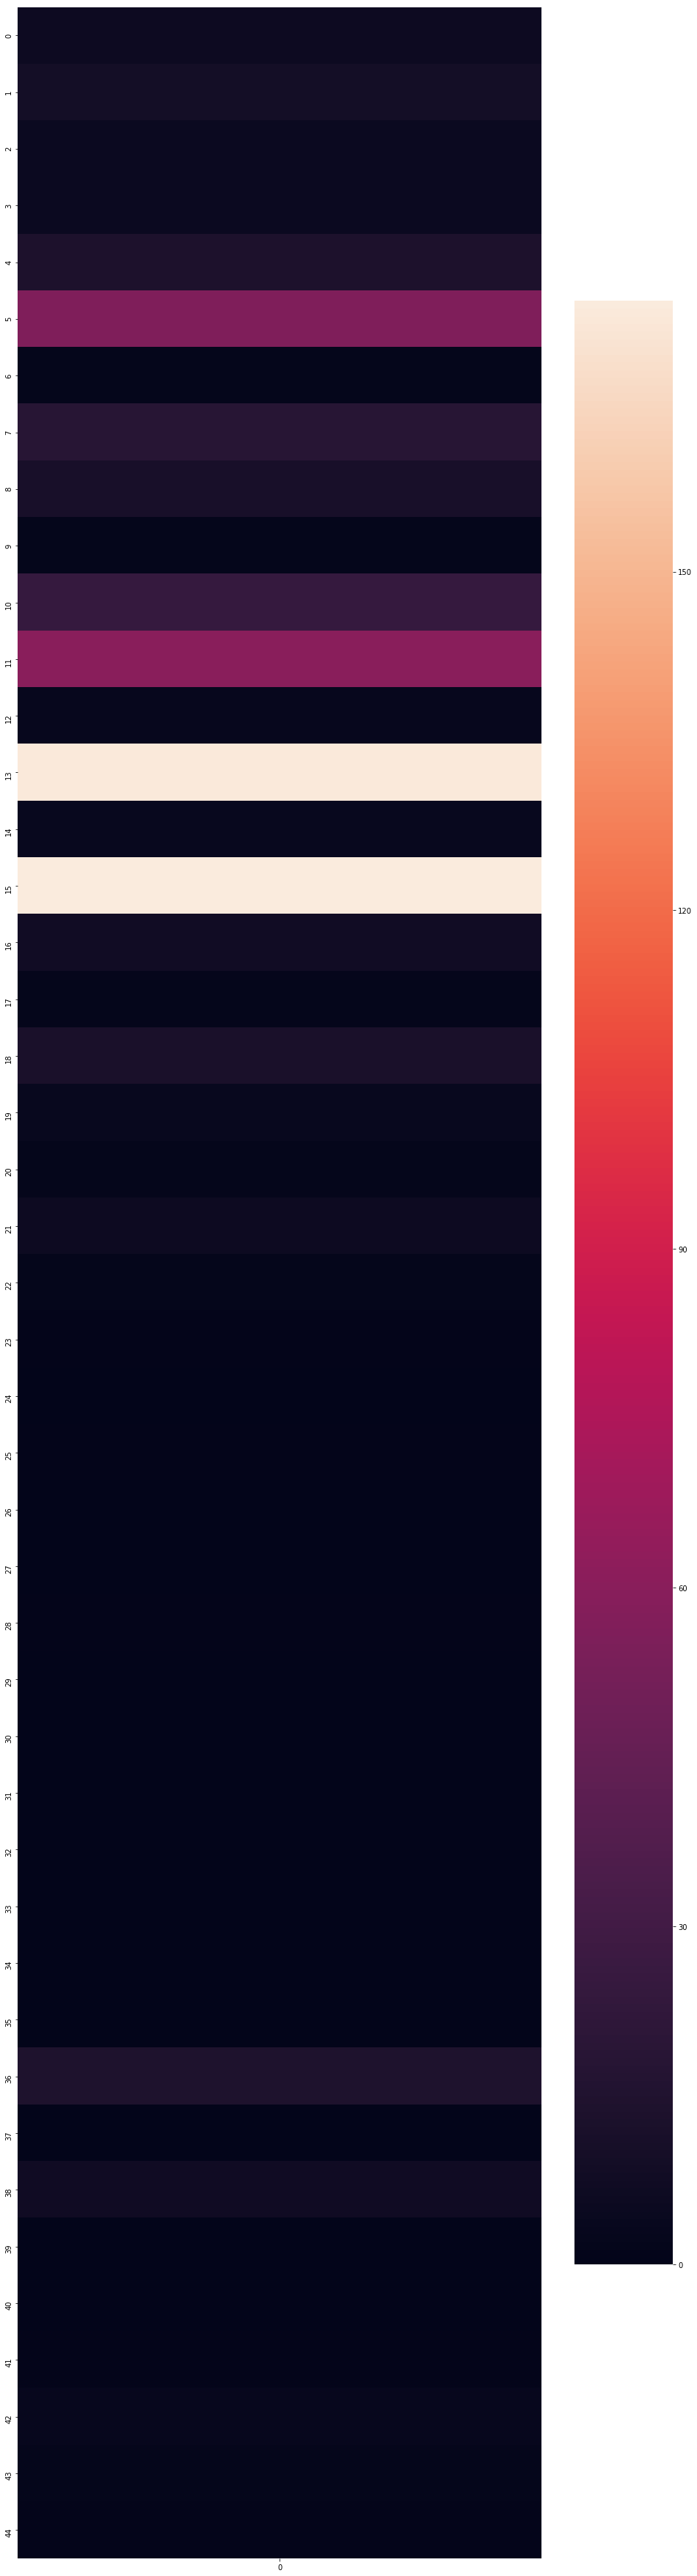

In [78]:
import seaborn as sns
import matplotlib.pyplot as plt

model_fail_cnts = []
for i in range(0, 45):
    fail_cnts = []
    for model in tme_history:
        fail_cnts.append(model.fail_cmp_stats[i])
    model_fail_cnts.append(fail_cnts)

plt.figure(figsize=(16, 64))
sns.heatmap(model_fail_cnts)

44 0.8988750195503235


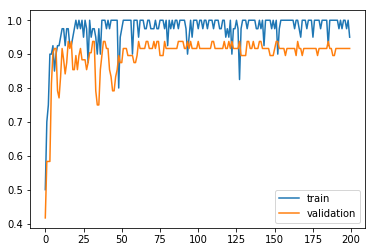

44 0.9083541885018349


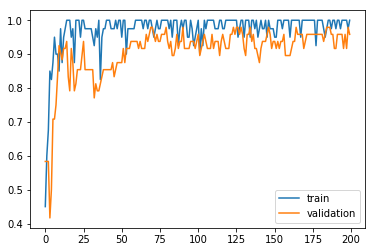

44 0.8557708549499512


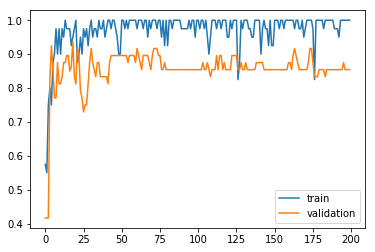

In [0]:
for th in tme_history:
    print(i, np.mean(th.val_ac_history))
    plt.plot(th.train_ac_history, label='train')
    plt.plot(th.val_ac_history, label='validation')
    plt.legend()
    plt.show()
    plt.pause(.001)
    

In [0]:
top_model = tme_history[0]
if len(tme_history) > 1:
    for tm in tme_history[1:]:
        if np.mean(tm.val_ac_history) > np.mean(top_model.val_ac_history):
            top_model = tm
model = top_model.model
    

In [0]:
!rm -rf test
!rm submission.csv

test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

test_dataset = ImageFolderWithPaths(test_dir, val_transforms)
test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=50, shuffle=False, num_workers=batch_size)

for tm in tme_history:
    tm.model.eval()

test_predictions = []
test_img_paths = []

for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        pr_preds = []
        for tm in tme_history:
            preds = tm.model(inputs)
            pr_preds.append(torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
        pp_result = pr_preds[0]
        for pp in pr_preds[1:]:
            pp_result += pp
        test_predictions.append(pp_result / len(tme_history))
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)

submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

submission_df.to_csv('submission.csv')

            

rm: cannot remove 'submission.csv': No such file or directory









  0%|          | 0/15 [00:00<?, ?it/s]






  7%|▋         | 1/15 [00:15<03:42, 15.91s/it]






 13%|█▎        | 2/15 [00:29<03:18, 15.29s/it]






 20%|██        | 3/15 [00:43<02:58, 14.86s/it]






 27%|██▋       | 4/15 [00:57<02:40, 14.57s/it]






 33%|███▎      | 5/15 [01:11<02:23, 14.36s/it]






 40%|████      | 6/15 [01:25<02:07, 14.22s/it]






 47%|████▋     | 7/15 [01:39<01:52, 14.11s/it]






 53%|█████▎    | 8/15 [01:52<01:38, 14.03s/it]






 60%|██████    | 9/15 [02:06<01:23, 13.99s/it]






 67%|██████▋   | 10/15 [02:20<01:09, 13.96s/it]






 73%|███████▎  | 11/15 [02:34<00:55, 13.93s/it]






 80%|████████  | 12/15 [02:48<00:41, 13.92s/it]






 87%|████████▋ | 13/15 [03:02<00:27, 13.90s/it]






 93%|█████████▎| 14/15 [03:16<00:13, 13.89s/it]






100%|██████████| 15/15 [03:28<00:00, 13.40s/it]








TypeError: ignored

rm: cannot remove 'submission.csv': No such file or directory


100%|██████████| 15/15 [00:22<00:00,  1.34s/it]


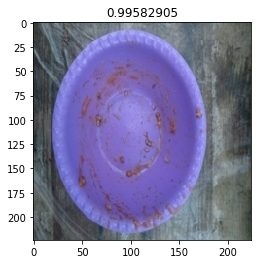

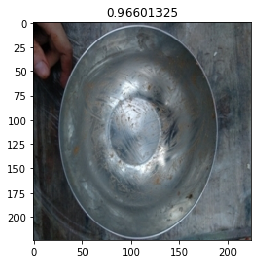

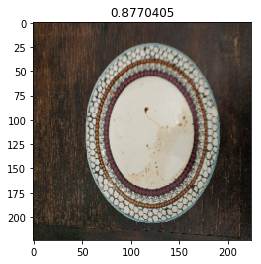

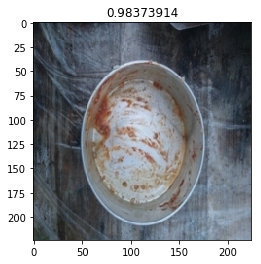

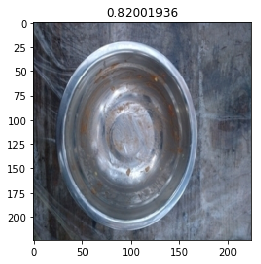

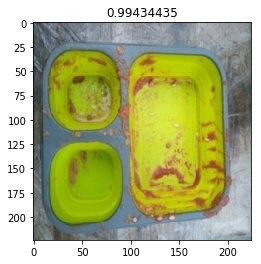

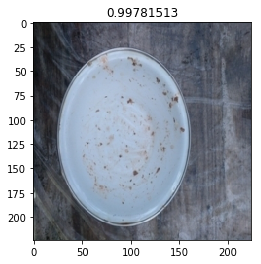

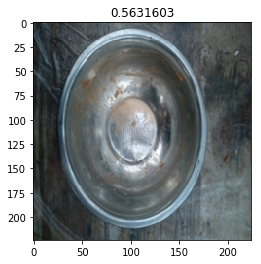

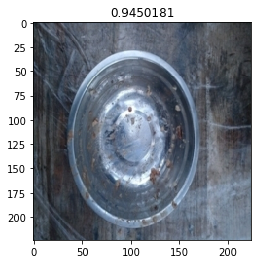

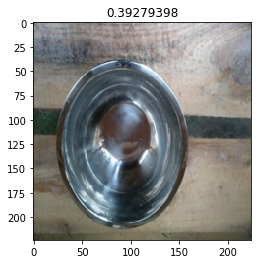

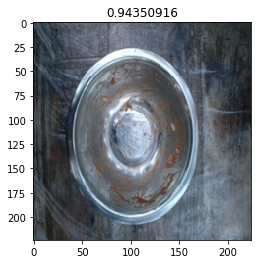

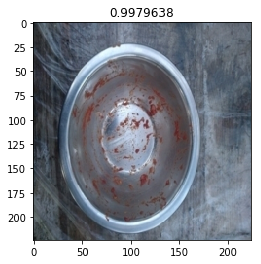

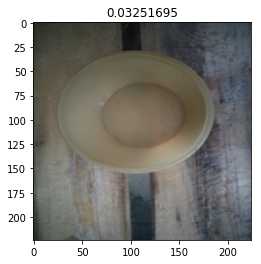

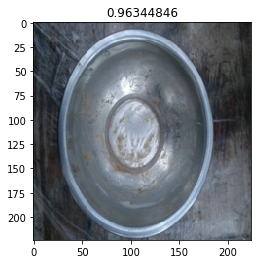

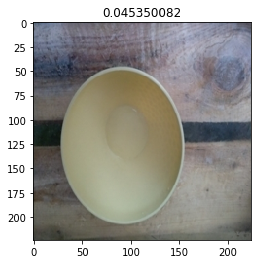

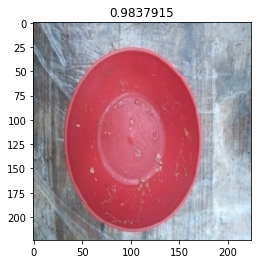

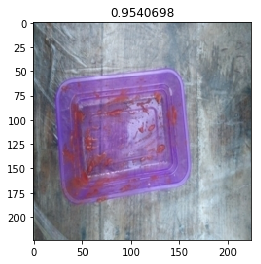

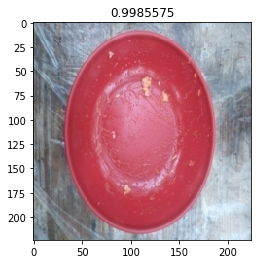

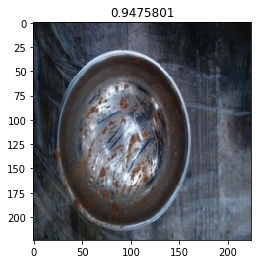

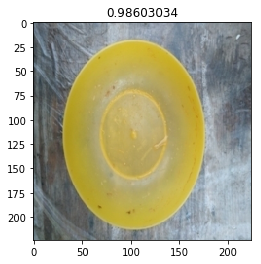

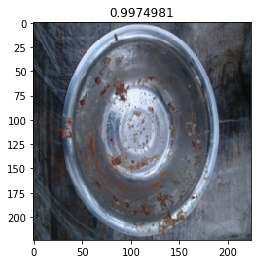

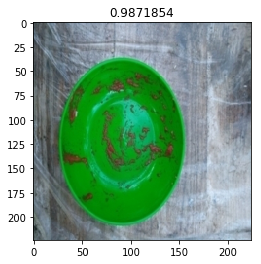

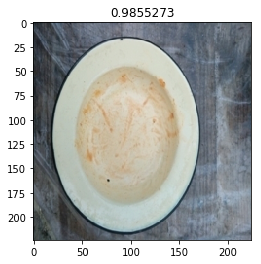

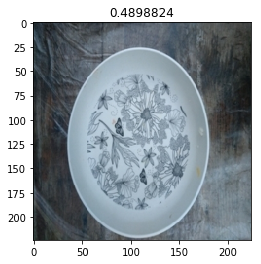

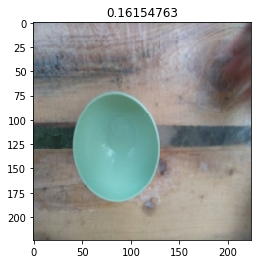

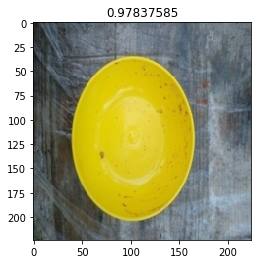

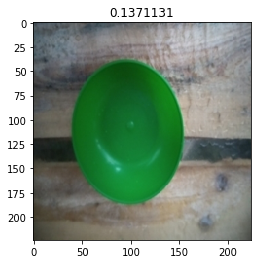

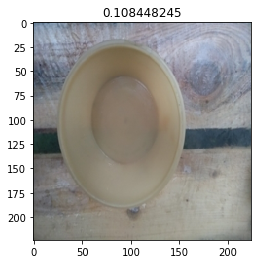

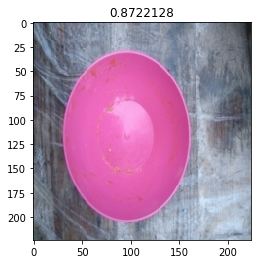

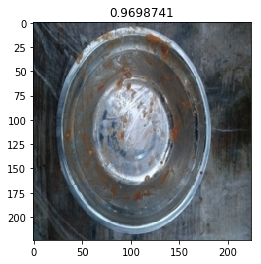

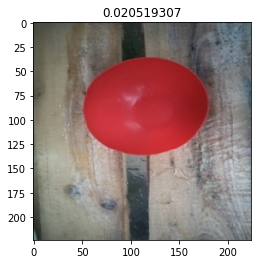

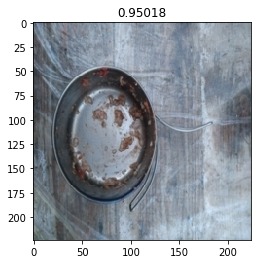

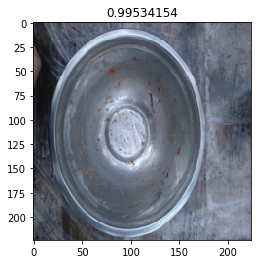

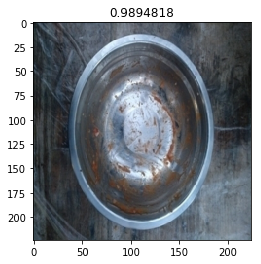

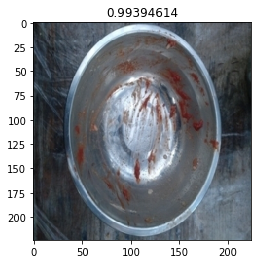

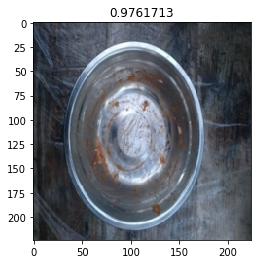

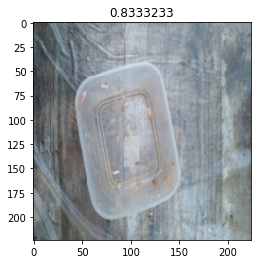

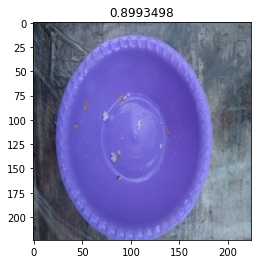

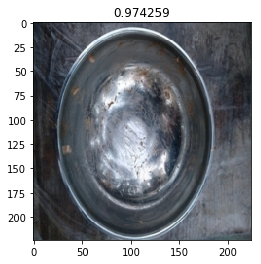

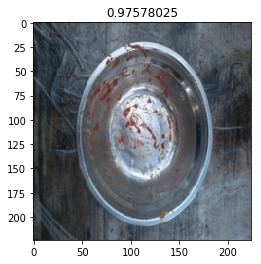

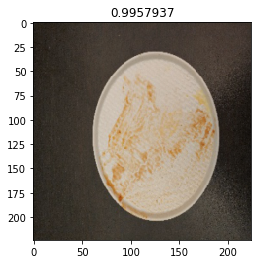

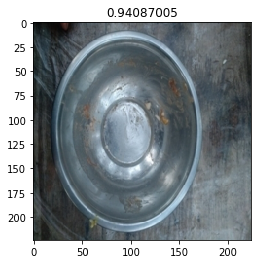

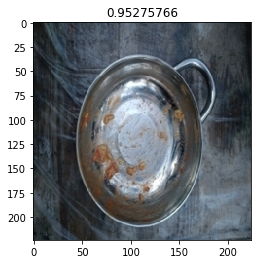

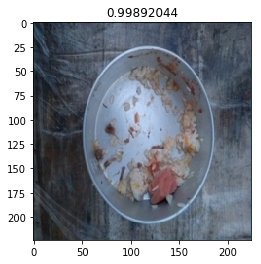

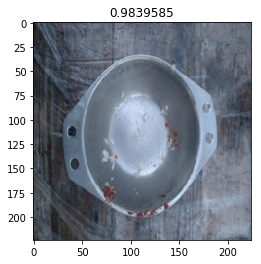

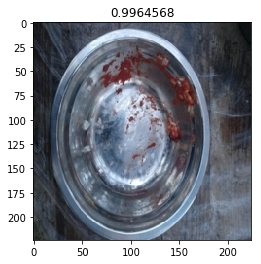

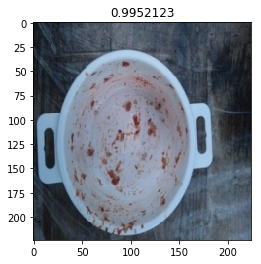

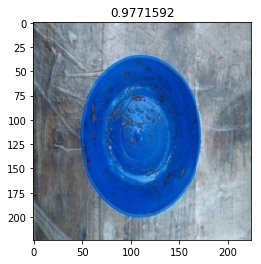

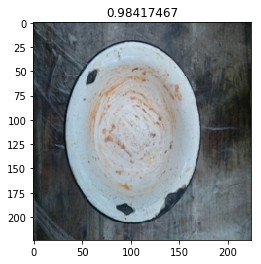

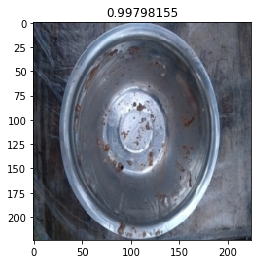

In [0]:
#%%

!rm -rf test
!rm submission.csv

test_dir = 'test'
shutil.copytree(os.path.join(data_root, 'test'), os.path.join(test_dir, 'unknown'))
model = tme_history[1].model

class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path
    
test_dataset = ImageFolderWithPaths(test_dir, val_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=50, shuffle=False, num_workers=batch_size)

model.eval()

test_predictions = []
test_img_paths = []
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        preds = model(inputs)
    test_predictions.append(
        torch.nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    test_img_paths.extend(paths)
    
test_predictions = np.concatenate(test_predictions)

inputs, labels, paths = next(iter(test_dataloader))

for img, pred in zip(inputs, test_predictions):
    show_input(img, title=pred)
    
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 'label': test_predictions})
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.5 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head(n=6)

submission_df.to_csv('submission.csv')

In [0]:
!ls -la

total 48
drwxr-xr-x 1 root root 4096 Jul 28 21:47 .
drwxr-xr-x 1 root root 4096 Jul 28 20:18 ..
drwxr-xr-x 1 root root 4096 Jul 19 16:14 .config
drwx------ 3 root root 4096 Jul 28 20:57 DRIVE
drwxr-xr-x 3 root root 4096 Jul 28 20:57 inputs
drwxr-xr-x 1 root root 4096 Jul 19 16:14 sample_data
-rw-r--r-- 1 root root 8653 Jul 28 21:47 submission.csv
drwxr-xr-x 3 root root 4096 Jul 28 21:47 test
drwxr-xr-x 4 root root 4096 Jul 28 21:01 train
drwxr-xr-x 4 root root 4096 Jul 28 21:01 val
